In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: M Arshad Zahangir Chowdhury

SVM implementations, cross-validations, 70%-30% train-test and experimental recognition in IR range.

"""

%matplotlib inline 

import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from ipywidgets import interactive
import seaborn as sns  #heat map
import glob # batch processing of images

if '../../' not in sys.path:
    sys.path.append('../../')

from src.spectral_datasets.IR_datasets import IR_data


from src.misc.utils import *

import datetime

#import metrics to evaluate classifiers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



# from sklearn.metrics import roc_curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold


from sklearn import svm
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier 

from scipy import interpolate
from sys import getsizeof

path_exp = "../../data/IR_Experimental_Data/"

## load IR spectra and view attributes

In [2]:
# Tunable frequency range, change data start and end location
s = IR_data(data_start = 400, data_end = 4000, resolution=1, verbosity = True)
s.load_IR_data()
print('Number of Compounds:', s.n_compounds)
print('Number of Spectrum:', s.n_spectrum)
print('Total Number of Spectra:', s.n_spectra)
print("Front trim :", s.front_trim_amount)
print("End trim :", s.end_trim_amount)
print('Data Start Input:',s.data_start)
print('Data End Input:',s.data_end)           
print('Sample Size of training data:', s.samplesize )
print('Rows discarded:', s.n_discard_rows)
print('Resolution (1/cm) = ', s.resolution)

print('\n labels of molecules present \n', s.labels)
print('\n target indices (integers) of molecules present', s.targets)
print('\n frequencies present in the data \n ', s.frequencies)

Front trim : 0.0
End trim : 0.0
Number of Compounds: 34
Number of Spectrum: 42
Total Number of Spectra: 1428
Front trim : 0.0
End trim : 0.0
Data Start Input: 400
Data End Input: 4000
Sample Size of training data: 3601
Rows discarded: 0
Resolution (1/cm) =  1.0
Loading H2O... 
H2O Data in Memory 
Loading CO2... 
CO2 Data in Memory 
Loading O3... 
O3 Data in Memory 
Loading N2O... 
N2O Data in Memory 
Loading CO... 
CO Data in Memory 
Loading CH4... 
CH4 Data in Memory 
Loading NO... 
NO Data in Memory 
Loading SO2... 
SO2 Data in Memory 
Loading NO2... 
NO2 Data in Memory 
Loading NH3... 
NH3 Data in Memory 
Loading HNO3... 
HNO3 Data in Memory 
Loading HF... 
HF Data in Memory 
Loading HCl... 
HCl Data in Memory 
Loading HF... 
HBr Data in Memory 
Loading HI... 
HI Data in Memory 
Loading OCS... 
OCS Data in Memory 
Loading H2CO... 
H2CO Data in Memory 
Loading HOCl... 
HOCl Data in Memory 
Loading HCN... 
HCN Data in Memory 
Loading CH3Cl... 
CH3Cl Data in Memory 
Loading H2O2... 
H2

In [3]:
X = s.spectra
y = s.targets
labels = s.labels
n_compounds = s.n_compounds
n_spectrum = s.n_spectrum
n_spectra = s.n_compounds*s.n_spectrum
samplesize = s.samplesize
wavenumbers = s.frequencies

In [4]:
#Check memory usages
X.nbytes

41137824

In [5]:
print('shape of features:', X.shape)
print('shape of labels:', y.shape)

shape of features: (1428, 3601)
shape of labels: (1428,)


## 70%-30% train-test split for classifiers SVM classifier with linear and RBF kernel

In [7]:
TRAIN_SIZE=0.70
TEST_SIZE=1-TRAIN_SIZE

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=123,
                                                   stratify=y
                                                   )

print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(train_y) / float(len(train_y))*100  )
print("Testing:", np.bincount(test_y) / float(len(test_y))*100  )

#Save the training data to calculate cross-validation score later
Val_train_X=train_X
Val_train_y=train_y

All: [2.94117647 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647
 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647
 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647
 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647
 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647 2.94117647
 2.94117647 2.94117647 2.94117647 2.94117647]
Training: [2.9029029 2.9029029 2.9029029 2.9029029 3.003003  3.003003  2.9029029
 3.003003  3.003003  2.9029029 2.9029029 3.003003  3.003003  2.9029029
 2.9029029 2.9029029 3.003003  2.9029029 3.003003  2.9029029 2.9029029
 2.9029029 2.9029029 2.9029029 3.003003  2.9029029 3.003003  3.003003
 2.9029029 2.9029029 3.003003  3.003003  2.9029029 2.9029029]
Testing: [3.03030303 3.03030303 3.03030303 3.03030303 2.7972028  2.7972028
 3.03030303 2.7972028  2.7972028  3.03030303 3.03030303 2.7972028
 2.7972028  3.03030303 3.03030303 3.03030303 2.7972028  3.03030303
 2.7972028  3.03030303 3.03030303 3.03030303 3.0303

In [8]:
indices = np.arange(n_spectra)

train_X, test_X, train_y, test_y, train_indices, test_indices = train_test_split(X, y, indices, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=123,
                                                   stratify=y
                                                   )


Fraction Correct[Accuracy]: 0.9976689976689976
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        13
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        12
          12       0.92      1.00      0.96        12
          13       1.00      1.00      1.00        13
          14       1.00      0.92      0.96        13
          15       1.00      1.00      1.00        13
          16       1.00      1.00 

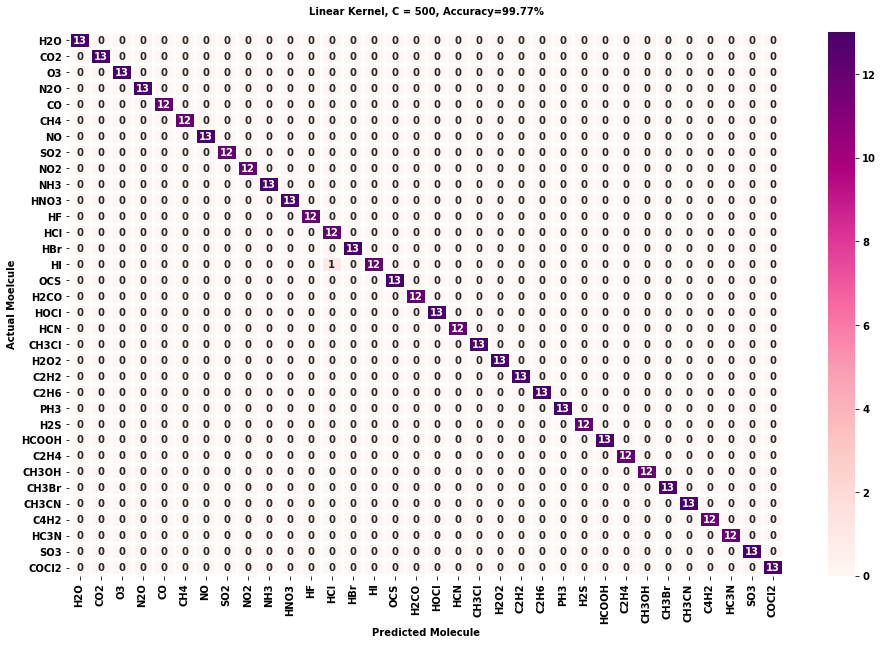

In [23]:
#OneVsRest (SVM-Linear Kernel)

#Measure time elapsed
t_start = datetime.datetime.now()

classifier_OVR = OneVsRestClassifier(SVC(kernel='linear',C = 500,decision_function_shape = 'ovo',random_state=1)).fit(train_X, train_y)
#USE C =259
#For this problem C = 200 did good


pred_y = classifier_OVR.predict(test_X)


FCA_OVR=np.sum(pred_y == test_y) / float(len(test_y))
print("Fraction Correct[Accuracy]:", FCA_OVR)

# Turn on classifier internals to see misclassification indices
#classifier_internals(pred_y,test_y, train_y, 'OneVsRest')


cm_OVR = confusion_matrix(test_y, pred_y)
plt.rc('font', weight='bold')
fig = plt.figure(figsize=(16,10));
ax = sns.heatmap(cm_OVR,linewidths=2, annot=True, cmap='RdPu');   #cmap='PiYG' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
plt.xlabel('Predicted Molecule',fontsize='medium', fontweight='bold');
plt.ylabel('Actual Moelcule',fontsize='medium', fontweight='bold');
plt.xticks(rotation=90);
plt.yticks(rotation=0);
plt.title('Linear Kernel, C = 500, Accuracy={0:0.2f}%\n'.format(FCA_OVR*100), fontsize='medium', fontweight='bold');
fig.savefig('RESULTS/Linear Kernel.jpg', bbox_inches='tight',dpi=300)


print(classification_report(test_y, pred_y))

t_end = datetime.datetime.now()
delta = t_end - t_start
Time_OVR=delta.total_seconds() * 1000

print('Time elaspsed: ', Time_OVR) # milliseconds

Fraction Correct[Accuracy]: 0.7855477855477856


/home/reshad812/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reshad812/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reshad812/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      0.69      0.82        13
           2       1.00      0.69      0.82        13
           3       1.00      0.85      0.92        13
           4       0.59      0.83      0.69        12
           5       1.00      0.92      0.96        12
           6       1.00      0.69      0.82        13
           7       1.00      0.83      0.91        12
           8       1.00      1.00      1.00        12
           9       1.00      0.92      0.96        13
          10       1.00      1.00      1.00        13
          11       1.00      0.83      0.91        12
          12       1.00      0.92      0.96        12
          13       1.00      0.69      0.82        13
          14       0.00      0.00      0.00        13
          15       0.76      1.00      0.87        13
          16       1.00      0.92      0.96        12
          17       1.00    

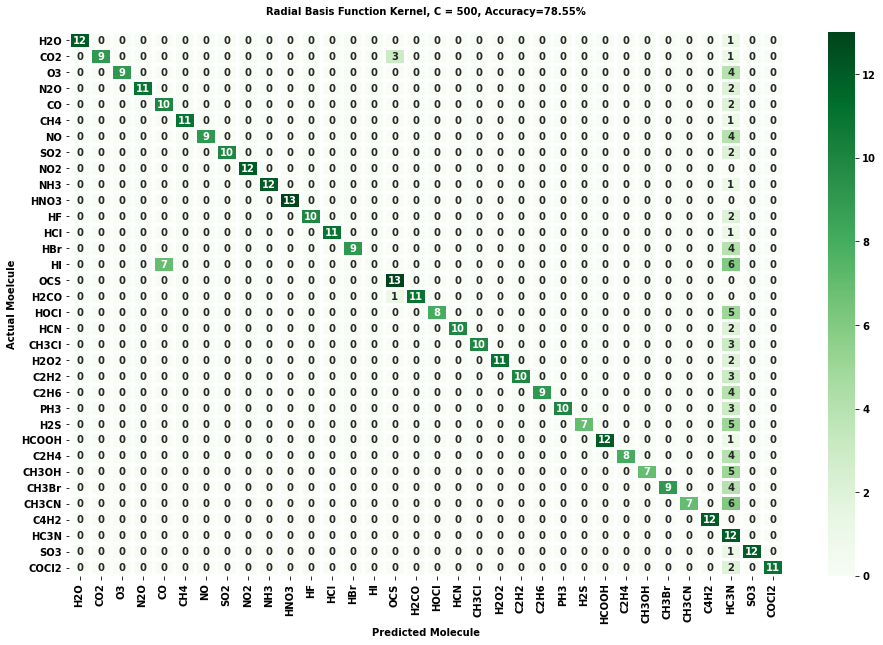

In [24]:
#OneVsRest (SVM-rbf Kernel)

#Measure time elapsed
import datetime
t_start = datetime.datetime.now()

classifier_OVR = OneVsRestClassifier(SVC(kernel='rbf',C = 500,decision_function_shape = 'ovo',random_state=1)).fit(train_X, train_y)
#USE C =259
#For this problem C = 200 did good


pred_y = classifier_OVR.predict(test_X)


FCA_OVR=np.sum(pred_y == test_y) / float(len(test_y))
print("Fraction Correct[Accuracy]:", FCA_OVR)

# Turn on classifier internals to see misclassification indices
#classifier_internals(pred_y,test_y, train_y, 'OneVsRest')

cm_OVR = confusion_matrix(test_y, pred_y)
plt.rc('font', weight='bold')
fig = plt.figure(figsize=(16,10));
# plt.title('Confusion matrix (P = 1 atm, T=297 K) \n OVR(SVM-LIN) spectra-classifier(x=1)\n');
ax = sns.heatmap(cm_OVR,linewidths=2, annot=True, cmap='Greens');   #cmap='PiYG' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
plt.xlabel('Predicted Molecule',fontsize='medium', fontweight='bold');
plt.ylabel('Actual Moelcule',fontsize='medium', fontweight='bold');
plt.xticks(rotation=90);
plt.yticks(rotation=0);
plt.title('Radial Basis Function Kernel, C = 500, Accuracy={0:0.2f}%\n'.format(FCA_OVR*100), fontsize='medium', fontweight='bold');
fig.savefig('RESULTS/RBF Kernel.jpg', bbox_inches='tight',dpi=300)

print(classification_report(test_y, pred_y))

t_end = datetime.datetime.now()
delta = t_end - t_start
Time_OVR=delta.total_seconds() * 1000

print('Time elaspsed: ', Time_OVR) # milliseconds

## notebook ends